<a href="https://colab.research.google.com/github/amir-asari/Qwen-VL-Basic/blob/main/QWen2_VL_ZeroShotObjectDetectionCOCO.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
import re

#### --- 1. Environment Setup and Installation ---

In [2]:
# This block installs/upgrades libraries and forces a runtime restart.
print("Installing necessary packages...")


!pip install -q git+[https://github.com/huggingface/transformers.git](https://github.com/huggingface/transformers.git) accelerate
!pip install -q -U bitsandbytes
!pip install -q qwen-vl-utils pillow

Installing necessary packages...
/bin/bash: -c: line 1: syntax error near unexpected token `('
/bin/bash: -c: line 1: `pip install -q git+[https://github.com/huggingface/transformers.git](https://github.com/huggingface/transformers.git) accelerate'
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.1/59.1 MB 16.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.5/40.5 MB 20.2 MB/s eta 0:00:00


#### --- 2. Imports and Model Loading (with 4-bit Quantization) ---

In [3]:
import torch
import warnings
import json
from PIL import Image, ImageOps
import requests
from io import BytesIO
from transformers import Qwen2VLForConditionalGeneration, AutoTokenizer, AutoProcessor, BitsAndBytesConfig
from IPython.display import display
import matplotlib.pyplot as plt
import matplotlib.patches as patches

warnings.filterwarnings('ignore')

# Switched to Qwen2-VL (2B version) for stability and T4 GPU compatibility
MODEL_ID = "Qwen/Qwen2-VL-2B-Instruct"

if torch.cuda.is_available():
    device = "cuda"
    dtype = torch.float16
else:
    device = "cpu"
    dtype = torch.float32

print(f"--- Environment Setup ---")
print(f"Device: {device} | Loading: {MODEL_ID}")

model = None
try:
    bnb_config = BitsAndBytesConfig(
        load_in_4bit=True,
        bnb_4bit_quant_type="nf4",
        bnb_4bit_compute_dtype=torch.float16
    )
    tokenizer = AutoTokenizer.from_pretrained(MODEL_ID)
    processor = AutoProcessor.from_pretrained(MODEL_ID)

    # Note the specific class for Qwen2VL
    model = Qwen2VLForConditionalGeneration.from_pretrained(
        MODEL_ID,
        quantization_config=bnb_config,
        torch_dtype=dtype,
        device_map="auto",
    ).eval()
    print("Qwen2-VL loaded successfully.")
except Exception as e:
    print(f"Error loading Qwen2-VL: {e}")
    model = None


--- Environment Setup ---
Device: cuda | Loading: Qwen/Qwen2-VL-2B-Instruct


tokenizer_config.json: 0.00B [00:00, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

preprocessor_config.json:   0%|          | 0.00/347 [00:00<?, ?B/s]

The image processor of type `Qwen2VLImageProcessor` is now loaded as a fast processor by default, even if the model checkpoint was saved with a slow processor. This is a breaking change and may produce slightly different outputs. To continue using the slow processor, instantiate this class with `use_fast=False`. Note that this behavior will be extended to all models in a future release.


chat_template.json: 0.00B [00:00, ?B/s]

`torch_dtype` is deprecated! Use `dtype` instead!


config.json: 0.00B [00:00, ?B/s]

model.safetensors.index.json: 0.00B [00:00, ?B/s]

Fetching 2 files:   0%|          | 0/2 [00:00<?, ?it/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/3.99G [00:00<?, ?B/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/429M [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/272 [00:00<?, ?B/s]

Qwen2-VL loaded successfully.


#### --- 3. Zero-Shot Detection Function ---

In [47]:
def zero_shot_detect(image_url: str, query_object: str):
    """
    Improved detection using standard [xmin, ymin, xmax, ymax] order to fix rotation issues.
    Numbers are extracted robustly from grounding tags or plain text.
    """
    if model is None:
        return {"error": "Model failed to load."}

    try:
        headers = {'User-Agent': 'Mozilla/5.0'}
        response = requests.get(image_url, stream=True, headers=headers)
        response.raise_for_status()

        # Load and handle orientation metadata to prevent shifted/rotated boxes
        image = Image.open(BytesIO(response.content)).convert("RGB")
        image = ImageOps.exif_transpose(image)
    except Exception as e:
        return {"error": f"Image load error: {e}"}

    # Prompting for high-precision grounding in standard X-first order
    prompt_instruction = (
        f"Find all the '{query_object}' in the image. "
        f"For each one, provide the bounding box as [xmin, ymin, xmax, ymax] scaled to 1000. "
        f"Point (0,0) is top-left and (1000,1000) is bottom-right."
    )

    conversation = [
        {"role": "system", "content": [{"type": "text", "text": "You are a precise object detector. Always use the order [xmin, ymin, xmax, ymax] for your coordinates."}]},
        {"role": "user", "content": [{"type": "image", "image": image}, {"type": "text", "text": prompt_instruction}]}
    ]

    try:
        # Standard resolution for zero-shot detection
        inputs = processor(
            text=[processor.apply_chat_template(conversation, tokenize=False, add_generation_prompt=True)],
            images=[image],
            padding=True,
            return_tensors="pt"
        ).to(device)

        output_ids = model.generate(**inputs, do_sample=False, max_new_tokens=1024)
        response_text = tokenizer.decode(output_ids[0], skip_special_tokens=False)

        # Isolate assistant text
        assistant_output = response_text.split("assistant\n")[-1].strip()

        # Robustly extract all digit sequences
        numbers = re.findall(r"\d+", assistant_output)
        detections = []

        # Process in chunks of 4: [xmin, ymin, xmax, ymax]
        for i in range(0, len(numbers) - 3, 4):
            try:
                xmin, ymin, xmax, ymax = map(int, numbers[i:i+4])

                # Validation: 0-1000 range
                if all(0 <= v <= 1000 for v in [xmin, ymin, xmax, ymax]):
                    detections.append({
                        "box": [xmin, ymin, xmax, ymax],
                        "label": query_object
                    })
            except ValueError:
                continue

        if not detections:
            print(f"DEBUG: No valid boxes found. Raw response: {assistant_output}")
            return {"image": image, "detections": [], "error": "No coordinates detected."}

    except Exception as e:
        return {"image": image, "detections": [], "error": str(e)}

    return {"image": image, "detections": detections, "error": None}

def draw_detections(image: Image.Image, detections: list, title: str):
    """
    Maps [xmin, ymin, xmax, ymax] to pixels with high precision.
    """
    if not detections:
        display(image)
        return

    fig, ax = plt.subplots(1, figsize=(12, 12))
    ax.imshow(image)
    ax.set_title(title)

    # Capture dimensions exactly as they appear in the plot
    img_w, img_h = image.size

    for det in detections:
        try:
            # Consistent X-first coordinate order
            xmin_n, ymin_n, xmax_n, ymax_n = det['box']

            # Use high-precision float mapping
            x_min = (float(xmin_n) / 1000.0) * img_w
            y_min = (float(ymin_n) / 1000.0) * img_h
            x_max = (float(xmax_n) / 1000.0) * img_w
            y_max = (float(ymax_n) / 1000.0) * img_h

            width = x_max - x_min
            height = y_max - y_min

            # Skip invalid or tiny boxes
            if width <= 1 or height <= 1: continue

            # Plot using standard matplotlib patches (X, Y, W, H)
            rect = patches.Rectangle((x_min, y_min), width, height,
                                     linewidth=2, edgecolor='#00FF00', facecolor='none')
            ax.add_patch(rect)

            label = det.get('label', 'Obj')
            plt.text(x_min, y_min - 5, label, color='white', weight='bold', size=10,
                     bbox=dict(facecolor='#00FF00', alpha=0.7, edgecolor='none', pad=2))
        except Exception as e:
            print(f"Drawing error: {e}")

    ax.axis('off')
    plt.show()

####--- 4. Zero-Shot Detection Dataset and Execution ---


--- Starting Detection ---

Processing: person


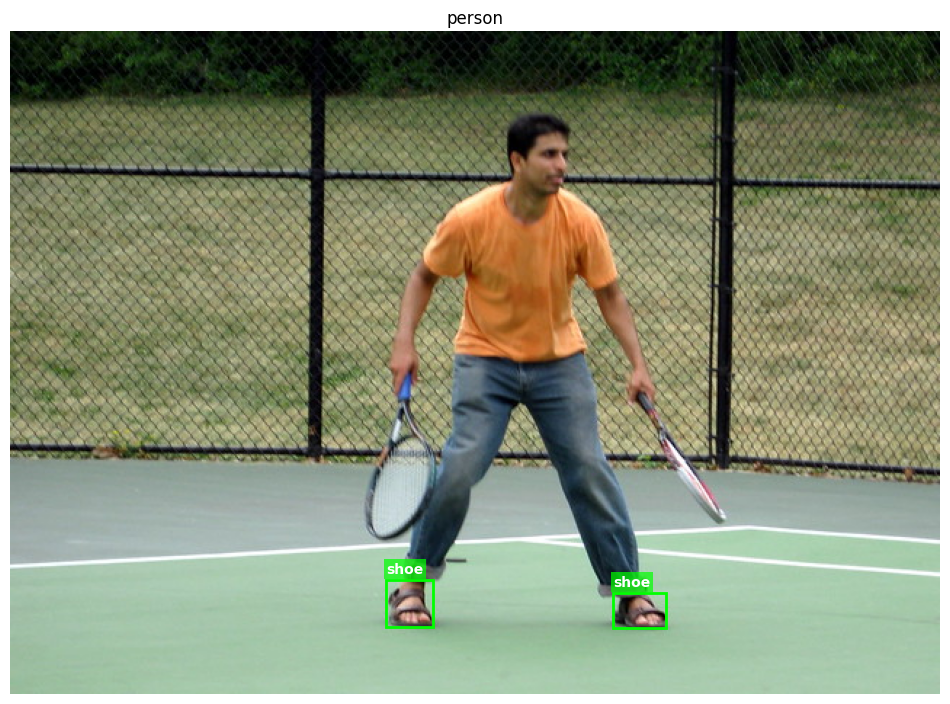

In [53]:
print("\n--- Starting Detection ---")
detection_dataset = [
    {"url": "https://farm3.staticflickr.com/2609/3725285646_8b3fd212a0_z.jpg", "query": "shoe", "title": "person"},
    # {"url": "http://images.cocodataset.org/val2017/000000000139.jpg", "query": "all object with rectangle shape", "title": "person"},
    # {"url": "http://images.cocodataset.org/val2017/000000000285.jpg", "query": "any region with circle shape", "title": "ear"},
    # {"url": "http://images.cocodataset.org/val2017/000000000785.jpg", "query": "red", "title": "head"}
]

for item in detection_dataset:
    print(f"\nProcessing: {item['title']}")
    result = zero_shot_detect(item["url"], item["query"])
    if not result.get('error'):
        draw_detections(result['image'], result['detections'], item['title'])


#### --- 5. Performance Summary ---

In [ ]:
print("\n\n" + "="*50)
print("--- 5. Object Detection Performance Summary ---")
print("="*50)

if total_runs > 0:
    parse_success_rate = (successful_parses / total_runs) * 100
    print(f"Total Test Runs: {total_runs}")
    print(f"Successful JSON Parses: {successful_parses}")
    print(f"JSON Parsing Success Rate: {parse_success_rate:.2f}%")
    print("\nNote: True detection accuracy (IoU) is not calculated here, as it requires ground-truth bounding box data.")
else:
    print("No test runs were executed.")



--- 5. Object Detection Performance Summary ---
Total Test Runs: 3
Successful JSON Parses: 3
JSON Parsing Success Rate: 100.00%

Note: True detection accuracy (IoU) is not calculated here, as it requires ground-truth bounding box data.
